In [1]:
import pandas as pd
import numpy as np
import glob

In [2]:
pip install spotipy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_id = '34fd877d2ddb4305ab79222521608e23'
client_secret = '038aac820f624a37b72bbd83480da3bd'

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
''' path = 'musicCBR/datasets_raw/BigML_lyrics.csv.zip'
data_lyrics = pd.read_csv(path)
data_lyrics.dropna(inplace = True)
data_lyrics.reset_index(drop=True,inplace=True) '''

# Data wrangling 

In [ ]:
def find_track_id_database(database):

  """
  Function to find all the Spotify track ID's using the track name and artist of the lyrics dataset.
  This function is quite slow and the Spotify API doens't allow to run the whole dataset at once.
  Run this function multiple times over subsets of the data.
  """

  song_ids = []
  n = 1000
  len_data = len(database)

  for i in range(len(database)):

    results = sp.search(q= 'track: {} artist: {}'.format(database['Song'][i], database['Band'][i]), limit=1)

    if results['tracks']['items'] == []:
      song_ids.append(np.nan)
    else:
      track_id = results['tracks']['items'][0]['id']
      song_ids.append(track_id)

    if i % n == 0:
      print('{} of {} tracks'.format(i,len_data))
    
  database['id'] = song_ids
  database.dropna(inplace = True)
  database.reset_index(drop = True, inplace = True)

  database.to_csv('musicCBR/data_wrangling_exploration/lyrics_id_subsets/data_lyrics_ids_30000.csv')

  return database

In [ ]:
def data_lyrics_load():
  """
  Load the multiple .csv files created by running find_track_id_database on subsets of the lyrics dataset.
  Concatenate the files and output a concatenated dataframe with the track ID's and lyrics and a lookup table to link the ID's with the track names and artists.
  """

  paths = glob.glob('musicCBR/data_wrangling_exploration/lyrics_id_subsets/*.csv')

  dataframes = []
  for i in range(len(paths)):
    data = pd.read_csv(paths[i])
    dataframes.append(data)

  #concatenate seperate dataframes
  data_lyrics = pd.concat(dataframes)
  data_lyrics.drop_duplicates(subset='id', inplace=True)

  # Create lookup table to link id's and track title/artist
  id_lookup = data_lyrics[['Song','Band','id']]
  id_lookup.reset_index(drop=True, inplace=True)

  # Dataframe with song id's and lyrics
  data_lyrics = data_lyrics[['id','Lyrics']]
  data_lyrics.reset_index(drop=True, inplace=True)

  return data_lyrics, id_lookup

In [ ]:
def get_audio_features(dataset):

  """
  Function to get the Spotify audio features of a dataframe using the Spotify track ID's.
  """
  dataframes = []
  len_data = len(dataset)
  n = 10000

  for i in range(0, len(dataset), 100):
    list_ids = list(dataset['id'][i:i+100].values)
    audio_features = sp.audio_features(list_ids)
    audio_features = [i for i in audio_features if i]

    df_features = pd.DataFrame(audio_features)
    df_features = df_features[['id','danceability','energy', 'loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]

    dataframes.append(df_features)

    if i % n == 0:
      print('{} of {} tracks'.format(i,len_data))

  data_lyrics_concat = pd.concat(dataframes)
  data_lyrics_features = dataset.merge(data_lyrics_concat, how='inner', on='id')

  data_lyrics_features.to_csv('musicCBR/data/data_lyrics_features.csv.zip')

  return data_lyrics_features

# Data exploration

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
path = '/home/robin/git_projects/musicCBR/data/data_lyrics_features.csv.zip'
data = pd.read_csv(path, )
data.head()

,Unnamed: 0,id,Lyrics,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,2ne4ZuEhn35sGRftyI8jJP,"No, no\r\nI ain't ever trapped out the bando\r...",0.783,0.563,-8.613,0.2330,0.370000,0.000000,0.1090,0.634,114.897
1,1,6lHGPW1IW2w5rQ3FFqqmkx,"The drinks go down and smoke goes up, I feel m...",0.781,0.571,-10.630,0.0723,0.065700,0.175000,0.1140,0.631,124.021
2,2,6QHWyeh90gahr79P36m7gQ,She don't live on planet Earth no more\r\nShe ...,0.705,0.764,-7.407,0.0862,0.016800,0.000036,0.1340,0.240,159.995
3,3,3mBEewFYvVpVIVAFnuECyR,"Trippin' off that Grigio, mobbin', lights low\...",0.404,0.523,-7.099,0.0485,0.644000,0.000004,0.1330,0.537,134.385
4,4,4PoGx0KVpaqVWxSF9j11O3,"I see a midnight panther, so gallant and so br...",0.293,0.604,-8.742,0.0426,0.000607,0.000015,0.0877,0.375,79.946


<ipython-input-18-54f4d5913751>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(data.drop(['id','Lyrics'],axis=1).corr(), dtype=np.bool))


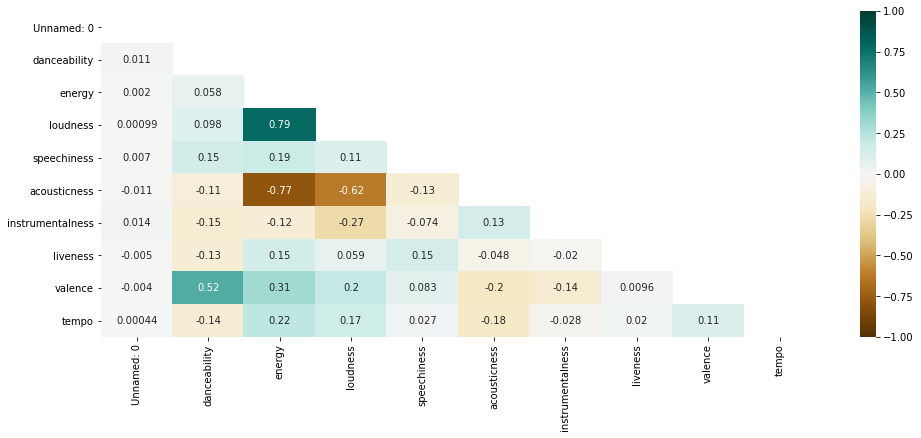

In [18]:
plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(data.drop(['id','Lyrics'],axis=1).corr(), dtype=np.bool))
heatmap = sns.heatmap(data.drop(['id','Lyrics'],axis=1).corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')